In [57]:
%matplotlib inline

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd
import torch.nn.functional as F
from torchvision import datasets, transforms, models

import matplotlib.pyplot as plt

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.utils import shuffle
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from typing import Tuple

rng = np.random.RandomState(1234)
random_state = 42

In [58]:
# Model Hyperparameters

dataset_path = './data'

device = 'cuda' if torch.cuda.is_available() else 'mps' if torch.has_mps or torch.backends.mps.is_available() else 'cpu'
print(f'Using device: {device}')

batch_size = 64

x_dim = 784
hidden_dim = 400
latent_dim = 200

lr = 1e-3

epochs = 10

Using device: mps


/var/folders/w9/d3h7vx393175sc9kvpd02znh0000gn/T/ipykernel_48222/47643077.py:5: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  device = 'cuda' if torch.cuda.is_available() else 'mps' if torch.has_mps or torch.backends.mps.is_available() else 'cpu'


## Step 1. Load(or download) Dataset

In [59]:
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.view(-1))
    ]
)

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(dataset_path, train=True, download=True, transform=transform),
    batch_size=batch_size,
    shuffle=True,
)

val_loader = torch.utils.data.DataLoader(
    datasets.MNIST(dataset_path, train=False, download=True, transform=transform),
    batch_size=batch_size,
    shuffle=False,
)

## Step 2. Define our model: Variational AutoEncoder (VAE)

In [60]:
def torch_log(x: torch.Tensor) -> torch.Tensor:
    """ prevent torch.log(0) = nan """
    return torch.log(torch.clamp(x, min=1e-10))

In [61]:
class Encoder(nn.Module):
    
    def __init__(self, input_dim: int, hidden_dim: int, latent_dim: int) -> None:
        """ Encoder for the VAE """
        super(Encoder, self).__init__()

        self.dense_enc1 = nn.Linear(input_dim, hidden_dim)
        self.dense_enc2 = nn.Linear(hidden_dim, hidden_dim)
        self.dense_encmean = nn.Linear(hidden_dim, latent_dim)
        self.dense_encvar = nn.Linear (hidden_dim, latent_dim)
        
        self.training = True
        
    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        x = F.relu(self.dense_enc1(x))
        x = F.relu(self.dense_enc2(x))
        mean = self.dense_encmean(x)
        std = F.softplus(self.dense_encvar(x))
        
        return mean, std

In [62]:
class Decoder(nn.Module):
    
    def __init__(self, latent_dim: int, hidden_dim: int, output_dim: int) -> None:
        """ Decoder for the VAE """
        super(Decoder, self).__init__()
        
        self.dense_dec1 = nn.Linear(latent_dim, hidden_dim)
        self.dense_dec2 = nn.Linear(hidden_dim, hidden_dim)
        self.dense_dec3 = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = F.relu(self.dense_dec1(x))
        x = F.relu(self.dense_dec2(x))
        # sigmoid activation to get the output in the range [0, 1]
        x = torch.sigmoid(self.dense_dec3(x))
        
        return x
        

In [63]:
class Model(nn.Module):
    def __init__(self, Encoder, Decoder):
        super(Model, self).__init__()
        self.Encoder = Encoder
        self.Decoder = Decoder
        
    def reparameterization(self, mean: torch.Tensor, std: torch.Tensor) -> torch.Tensor:
        """ Reparameterization trick """
        if self.Encoder.training:
            epsilon = torch.randn(mean.shape).to(device)
            return mean + epsilon * std
        else:
            return mean
    
    def loss_function(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        """ Loss function for the VAE """
        mean, std = self.Encoder(x)
        
        KL = -0.5 * torch.sum(1 + torch_log(std**2) - mean**2 - std**2, dim=1).mean()
        
        z = self.reparameterization(mean, std)
        x_hat = self.Decoder(z)
        
        reconstruction = torch.sum(x * torch_log(x_hat) + (1 - x) * torch_log(1 - x_hat), dim=1).mean()
        
        return KL, -reconstruction
                 
    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        """ Forward pass of the VAE """
        mean, std = self.Encoder(x)
        z = self.reparameterization(mean, std)
        x = self.Decoder(z)
        
        return x, z

In [64]:
encoder = Encoder(input_dim=x_dim, hidden_dim=hidden_dim, latent_dim=latent_dim)
decoder = Decoder(latent_dim=latent_dim, hidden_dim = hidden_dim, output_dim = x_dim)

model = Model(Encoder=encoder, Decoder=decoder).to(device)

### Step 3. Train Variational AutoEncoder (VAE)

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=lr)

for epoch in range(epochs):
    losses = []
    KL_losses = []
    reconstruction_losses = []
    
    model.train()
    for x, _ in train_loader:
        x = x.to(device)

        optimizer.zero_grad()
        
        KL_loss, reconstruction_loss = model.loss_function(x)
        
        loss = KL_loss + reconstruction_loss
        
        loss.backward()
        optimizer.step()
        
        losses.append(loss.cpu().detach().numpy())
        KL_losses.append(KL_loss.cpu().detach().numpy())
        reconstruction_losses.append(reconstruction_loss.cpu().detach().numpy())
        
    losses_val = []
    model.eval()
    for x, t in val_loader:
        x = x.to(device)

        KL_loss, reconstruction_loss = model.loss_function(x)
        
        loss = KL_loss + reconstruction_loss
        
        losses_val.append(loss.cpu().detach().numpy())

    print('EPOCH: %02d    Train Lower Bound↓: %lf (KL_loss↓: %lf. reconstruction_loss↓: %lf)    Valid Lower Bound↓: %lf' %
          (epoch+1, np.average(losses), np.average(KL_losses), np.average(reconstruction_losses), np.average(losses_val)))

EPOCH: 01    Train Lower Bound↓: 173.044983 (KL_loss↓: 10.463165. reconstruction_loss↓: 162.581802)    Valid Lower Bound↓: 139.351013


### Step 4. Generate image

### 4.1. Origin image

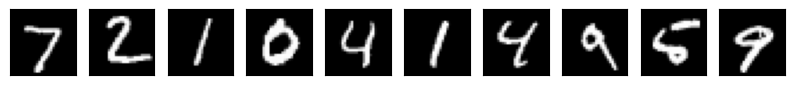

In [ ]:
valid_dataset = datasets.MNIST('./data/MNIST', train=False, download=True, transform=transform)
fig = plt.figure(figsize=(10, 10))
model.eval()
for i in range(10):
    x, t = valid_dataset[i]
    im = x.view(-1, 28, 28).permute(1, 2, 0).squeeze().numpy()

    ax = fig.add_subplot(4, 10, i+1, xticks=[], yticks=[])
    ax.imshow(im, 'gray')

### 4.2. Reconstruct image

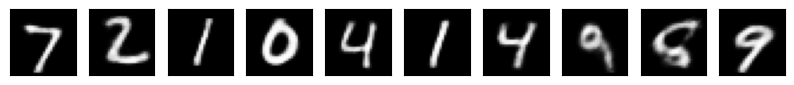

In [ ]:
fig = plt.figure(figsize=(10, 4))
model.eval()
for i in range(10):
    x, t = valid_dataset[i]

    x = x.unsqueeze(0).to(device)

    y, z = model(x)

    im = y.view(-1, 28, 28).permute(1, 2, 0).detach().cpu().squeeze().numpy()

    ax = fig.add_subplot(4, 10, i+1, xticks=[], yticks=[])
    ax.imshow(im, 'gray')

### 4.3. Random sampling from latent space

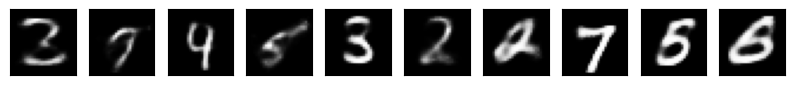

In [ ]:
z = torch.randn([10, latent_dim]).to(device)

fig = plt.figure(figsize=(10, 4))
model.eval()
for i in range(10):
    y = model.Decoder(z[i])

    im = y.view(-1, 28, 28).permute(1, 2, 0).detach().cpu().squeeze().numpy()

    ax = fig.add_subplot(4, 10, i+1, xticks=[], yticks=[])
    ax.imshow(im, 'gray')

### Step 5. Plot latent space

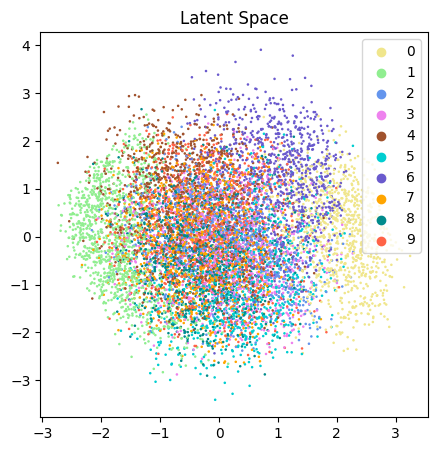

In [ ]:
model.eval()

z_list = []
t_list = []
for x, t in valid_dataset:
    t_list.append(t)
    x = x.to(device).unsqueeze(0)
    _, z = model(x)
    z_list.append(z.cpu().detach().numpy()[0])

z_val = np.stack(z_list)

REDUC  ='PCA'

if latent_dim > 2:
    if REDUC == "TSNE":
        z_reduc = TSNE(n_components=2).fit_transform(z_val).T
    elif REDUC == "PCA":
        z_reduc = PCA(n_components=2).fit_transform(z_val).T
    else:
        raise ValueError("Please choose dimensionality reduction method from TSNE or PCA.")
elif latent_dim == 2:
    z_reduc = z_val.T
else:
    raise ValueError("z dimensionality must be larger or equal to 2.")

colors = ['khaki', 'lightgreen', 'cornflowerblue', 'violet', 'sienna',
          'darkturquoise', 'slateblue', 'orange', 'darkcyan', 'tomato']

plt.figure(figsize=(5,5))
plt.scatter(*z_reduc, s=0.7, c=[colors[t] for t in t_list])
plt.title('Latent Space')
for i in range(10):
    plt.scatter([],[], c=colors[i], label=i)
plt.legend()


### Step 6. Visualization of interpolation in latent space.

start sample label: 7
end sample label: 0


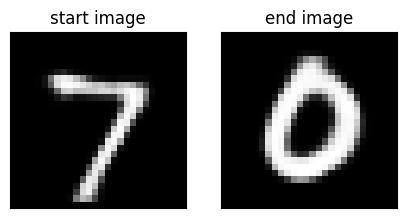

In [ ]:
START_SAMPLE_IDX = 0
END_SAMPLE_IDX = 3
TITLES = ["start", "end"]

model.eval()

z_dict = {}
fig = plt.figure(figsize=(5, 5))
for i, sample_idx in enumerate([START_SAMPLE_IDX, END_SAMPLE_IDX]):
    x, t = valid_dataset[sample_idx]
    print(f"{TITLES[i]} sample label: {t}")

    x = x.unsqueeze(0).to(device)
    y, z = model(x)

    image = y.view(-1, 28, 28).permute(1, 2, 0).detach().cpu().squeeze().numpy()
    z_dict.update({TITLES[i]: z})

    ax = fig.add_subplot(1, 2, i + 1, xticks=[], yticks=[])
    ax.set_title(f"{TITLES[i]} image")
    ax.imshow(image, 'gray')

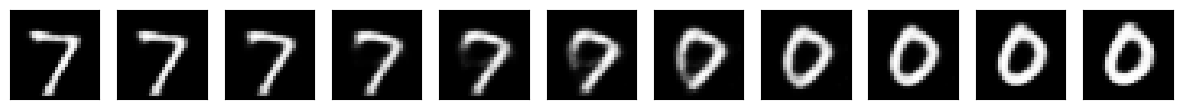

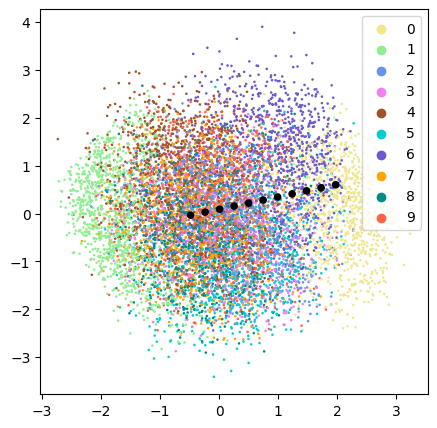

In [ ]:
z_interp = torch.cat(
    [torch.lerp(z_dict["start"], z_dict["end"], weight=w) for w in np.arange(0, 1.1, 0.1)]
)

images = model.Decoder(z_interp).view(-1, 28, 28).detach().cpu().numpy()

fig = plt.figure(figsize=(15, 15))
for i, im in enumerate(images):
    ax = fig.add_subplot(1, 11, i+1, xticks=[], yticks=[])
    ax.imshow(im, 'gray')

z_interp = np.concatenate([z_val, z_interp.detach().cpu().numpy()], axis=0)

REDUC = "PCA"
if latent_dim > 2:
    if REDUC == "TSNE":
        z_reduc = TSNE(n_components=2).fit_transform(z_interp).T
    elif REDUC == "PCA":
        z_reduc = PCA(n_components=2).fit_transform(z_interp).T
    else:
        raise ValueError("Please choose dimensionality reduction method from TSNE or PCA.")
elif latent_dim == 2:
    z_reduc = z_interp.T
else:
    raise ValueError("z dimensionality must be larger or equal to 2.")

t_list_interp = t_list + [10] * 11
colors_interp = colors + ["black"]
plt.figure(figsize=(5,5))
plt.scatter(
    *z_reduc,
    s=[0.7 if t < 10 else 20.0 for t in t_list_interp],
    c=[colors_interp[t] for t in t_list_interp]
)

for i in range(10):
    plt.scatter([],[], c=colors[i], label=i)
plt.legend()